In [1]:
### Imports, functions and global variables
import sys
import os
import re
from bs4 import BeautifulSoup as Soup
from collections import Counter
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
#import pyspark
#import numpy as np
#from pyspark import SparkContext
#from pyspark.mllib.fpm import FPGrowth

#SparkContext.setSystemProperty('spark.executor.memory','3g')
#sc = pyspark.SparkContext('local[*]')

## Global variables

totalquestions=0
totalQuestionswithacceptedanswers=0
totalQuestionswithnoacceptedanswers=0
bodydict=dict()

posts_by_tag = defaultdict()
tags_by_year = defaultdict()
tags_by_post_id = defaultdict()
userdict=dict()
tags=list()

acceptedanswers=list()
bestuser=list()

def populate_posts_by_tag(tag,post_id):
    global posts_by_tag
    if tag == '':
        return
    if post_id == '':
        return

    if tag not in posts_by_tag:
        posts_by_tag[tag] = set()
    posts_by_tag[tag].add(int(post_id))

def populate_tags_by_post_id(id,tag):
    global tags_by_post_id
    if tag == '':
        return
    if id == '':
        return

    if id not in tags_by_post_id:
        tags_by_post_id[id] = list()
    tags_by_post_id[id].append(tag)
    
def populate_tags_by_year(tag,year):
    global tags_by_year
    if tag == '':
        return
    if year == '':
        return

    if tag not in tags_by_year:
        tags_by_year[tag] = list()
    tags_by_year[tag].append(year)

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/100 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(8,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i+0.5,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()
    
def parse_posts(file):
    global totalquestions,totalQuestionswithacceptedanswers,totalQuestionswithnoacceptedanswers,bodydict

    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id = msg_attrs['id']     
            
            if 'body' in msg_attrs:
                #id=(msg_attrs[u'id'])
                body=(msg_attrs[u'body'])
                bodydict[id]=Soup(body,"html.parser").getText()

            if 'tags' in msg_attrs:
                year =  msg_attrs['creationdate'].split("-")[0]
                #print(year)
                msg_attrs=(msg_attrs[u'tags'].replace('<','').replace('>',','))
                for msg in msg_attrs.split(','):
                    tags.append(msg)
                    populate_posts_by_tag(msg,id)
                    populate_tags_by_year(msg,year)
                    populate_tags_by_post_id(id,msg)
            
            msg_attrs = dict(message.attrs)
            posttypeid = msg_attrs['posttypeid']
            
            if posttypeid == "1":
                totalquestions+=1
                if 'acceptedanswerid' in msg_attrs:
                    totalQuestionswithacceptedanswers+=1
                    acceptedanswerid = msg_attrs['acceptedanswerid']
                    acceptedanswers.append(acceptedanswerid)
                else:
                    totalQuestionswithnoacceptedanswers+=1
            else:
                if id in acceptedanswers and 'owneruserid' in msg_attrs:
                     bestuser.append(msg_attrs['owneruserid'])
                    
                #count=count+1

            # if count == 5:
            #     break
            
def parse_users(file):
    global userdict
    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id=(msg_attrs[u'id'])
            username=(msg_attrs[u'displayname'])
            userdict[id]=username                   

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
parse_posts("programmers.stackexchange.com/Posts.xml")
tags=list(filter(None, tags))
counts=dict()

top_20_words = Counter(tags).most_common(20)
print("Top 20 most common tags, and the number of their occurences :", top_20_words)

Top 20 most common tags, and the number of their occurences : [('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578), ('licensing', 1269), ('database', 1256), ('web-development', 1223), ('programming-languages', 1205), ('python', 1183), ('programming-practices', 1167), ('.net', 1084), ('unit-testing', 1063), ('c', 958), ('testing', 956)]


In [3]:
import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer,CountVectorizer,IDF

plt.style.use('fivethirtyeight')
SparkContext.setSystemProperty('spark.executor.memory','2g')
sc = pyspark.SparkContext('local[*]')
%matplotlib inline

In [6]:
sqlContext = SQLContext(sc)
body_df = sqlContext.createDataFrame(bodydict.items(), ["id", "post_body"])

In [8]:
body_df.show(truncate=True)

+------+--------------------+
|    id|           post_body|
+------+--------------------+
|269448|I need to find a ...|
| 54218|It's a beautiful,...|
| 28581|Ask yourself how ...|
|271376|It's clear to eve...|
|235938|I took your quest...|
|129601|Professional Atti...|
|272446|You could, instea...|
|255404|I understand most...|
|126997|using statements ...|
|273865|I have the follow...|
|186087|If you want to do...|
| 20699|I'm going to take...|
|329153|
Suppose I have 3...|
| 32482|So can an algorit...|
|127023|I was reading ano...|
|291328|I think that the ...|
|212334|.NET has an inter...|
|337295|Some languages cl...|
|121431|Not a full answer...|
|336458|Remainder is the ...|
+------+--------------------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

countTokens = udf(lambda words: len(words), IntegerType())

regexTokenizer = RegexTokenizer(inputCol="post_body", outputCol="words", pattern="[\W[0-9]*]")
tokenized = regexTokenizer.transform(body_df)
tokenized.select("post_body", "words")\
    .withColumn("tokens", countTokens(col("words"))).show(truncate=True)



+--------------------+--------------------+------+
|           post_body|               words|tokens|
+--------------------+--------------------+------+
|I need to find a ...|[i, need, to, fin...|   687|
|It's a beautiful,...|[it, s, a, beauti...|    63|
|Ask yourself how ...|[ask, yourself, h...|   591|
|It's clear to eve...|[it, s, clear, to...|    93|
|I took your quest...|[i, took, your, q...|   296|
|Professional Atti...|[professional, at...|   267|
|You could, instea...|[you, could, inst...|    58|
|I understand most...|[i, understand, m...|   260|
|using statements ...|[using, statement...|   115|
|I have the follow...|[i, have, the, fo...|   183|
|If you want to do...|[if, you, want, t...|   177|
|I'm going to take...|[i, m, going, to,...|   110|
|
Suppose I have 3...|[suppose, i, have...|   255|
|So can an algorit...|[so, can, an, alg...|    52|
|I was reading ano...|[i, was, reading,...|    85|
|I think that the ...|[i, think, that, ...|   210|
|.NET has an inter...|[net, has

In [16]:
def remove_stop_words(df, sw_file="stopwords_english.txt", ic="words"): 
    
    filter_words = sc.textFile("stopwords_english.txt").collect()
    stop_words_remover = StopWordsRemover(inputCol=ic, outputCol="filtered", stopWords=filter_words)
    new_df = stop_words_remover.transform(df)
    return new_df

filtered_df = remove_stop_words(tokenized)
filtered_df.show()

+------+--------------------+--------------------+--------------------+
|    id|           post_body|               words|            filtered|
+------+--------------------+--------------------+--------------------+
|269448|I need to find a ...|[i, need, to, fin...|[need, find, solu...|
| 54218|It's a beautiful,...|[it, s, a, beauti...|[beautiful, troub...|
| 28581|Ask yourself how ...|[ask, yourself, h...|[ask, much, added...|
|271376|It's clear to eve...|[it, s, clear, to...|[clear, everyone,...|
|235938|I took your quest...|[i, took, your, q...|[took, question, ...|
|129601|Professional Atti...|[professional, at...|[professional, at...|
|272446|You could, instea...|[you, could, inst...|[instead, using, ...|
|255404|I understand most...|[i, understand, m...|[understand, basi...|
|126997|using statements ...|[using, statement...|[using, statement...|
|273865|I have the follow...|[i, have, the, fo...|[following, simpl...|
|186087|If you want to do...|[if, you, want, t...|[want, dri, us

In [18]:
cv = CountVectorizer(inputCol="filtered", outputCol="features", minDF=2.0, vocabSize=1000)
cv_model = cv.fit(filtered_df)

result = cv_model.transform(filtered_df)

In [19]:
result.show()

+------+--------------------+--------------------+--------------------+--------------------+
|    id|           post_body|               words|            filtered|            features|
+------+--------------------+--------------------+--------------------+--------------------+
|269448|I need to find a ...|[i, need, to, fin...|[need, find, solu...|(1000,[1,2,4,5,6,...|
| 54218|It's a beautiful,...|[it, s, a, beauti...|[beautiful, troub...|(1000,[1,6,10,11,...|
| 28581|Ask yourself how ...|[ask, yourself, h...|[ask, much, added...|(1000,[0,6,9,12,1...|
|271376|It's clear to eve...|[it, s, clear, to...|[clear, everyone,...|(1000,[22,52,60,7...|
|235938|I took your quest...|[i, took, your, q...|[took, question, ...|(1000,[0,1,3,4,6,...|
|129601|Professional Atti...|[professional, at...|[professional, at...|(1000,[0,2,4,6,12...|
|272446|You could, instea...|[you, could, inst...|[instead, using, ...|(1000,[0,1,3,8,13...|
|255404|I understand most...|[i, understand, m...|[understand, basi...

In [20]:
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(result)

result = pca_model.transform(result)
result.show(truncate=True)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|           post_body|               words|            filtered|            features|         pcaFeatures|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+
|269448|I need to find a ...|[i, need, to, fin...|[need, find, solu...|(1000,[1,2,4,5,6,...|[-0.4673057240739...|
| 54218|It's a beautiful,...|[it, s, a, beauti...|[beautiful, troub...|(1000,[1,6,10,11,...|[-0.0331658734790...|
| 28581|Ask yourself how ...|[ask, yourself, h...|[ask, much, added...|(1000,[0,6,9,12,1...|[-0.3367331055777...|
|271376|It's clear to eve...|[it, s, clear, to...|[clear, everyone,...|(1000,[22,52,60,7...|[-0.0243552556321...|
|235938|I took your quest...|[i, took, your, q...|[took, question, ...|(1000,[0,1,3,4,6,...|[-0.4877592716069...|
|129601|Professional Atti...|[professional, at...|[professional, at...|(1000,[0,2,4,6,12

#### Plot the eigenvalues of the principal components. Calculate how many components are needed to explain 50% of the total variance?

#### Answer: 
Each of the components explain a part of the total variance. In order to find out the percentage of variance contributed by each component, we use cumulative sum of each component over total sum.

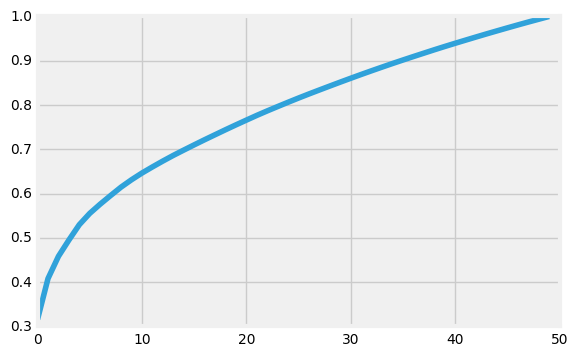

In [21]:
variance_fraction=np.cumsum(pca_model.explainedVariance)/np.sum(pca_model.explainedVariance)
plot_var = plt.plot(variance_fraction)

In [22]:
import bisect
index_of_nearest_width = bisect.bisect_left(variance_fraction, 0.5) 
print("50% of the variance is explained by", index_of_nearest_width, "components")

50% of the variance is explained by 4 components


#### c. Identify which words are important in each of the principal components. To do so, take the sum of squares of each of the component vectors to check how they are normalized. For each component, then print out the words for which the absolute value of the component is larger than 0.20 of the norm.

In [23]:
top_1000_words = cv_model.vocabulary
eigen_vectors = pca_model.pc.toArray().T

# print(np.sum(pc_array[0]**2))
for k,eigvec in enumerate(eigen_vectors):
    imp_words = [top_1000_words[w] for (w,c) in enumerate(np.abs(eigvec)) if c > 0.2]
    print(imp_words)
      

['x']
['code', 'class']
['code', 'class', 'public']
['code', 'data', 'public']
['c']
['code', 'data']
['class', 'function', 'value', 'return', 'int', 'n']
['data', 'class', 'c', 'object', 'public', 'function']
['test', 'tests', 'testing', 'unit']
['use', 'data', 'user', 'server']
['class', 'language', 'b', 'n']
['use', 'user', 'object', 'function', 'int', 'n']
['use', 'user', 'project', 'software', 'function', 'n']
['one', 'like', 'm', 'user', 'object', 'software', 'function', 'type']
['one', 'new', 'user', 'object', 'software', 'function']
['use', 'one', 'like', 'new', 'function', 'type']
['one', 'new', 'object', 'n']
['one', 'time', 'class', 'new', 'object', 'public', 'type', 'model']
['use', 'like', 'time', 'm', 'b', 'int', 'f']
['user', 'type', 'server', 'b', 'client', 'int', 'n']
['time', 'new', 'user', 'type', 'b', 'int', 'f']
['use', 'like', 'time', 'm', 'language', 'b', 'int', 'f']
['use', 'object', 'project', 'software', 'file', 'team', 'model']
['time', 're', 'project', 'soft

In [24]:
def plot_scatter(result,colnum,sample_size):
    s = result.take(sample_size)
    temp = []
    for x in s:
        temp.append(x[colnum])
    temp = np.array(temp)
    ATranspose = temp.transpose()
    plt.scatter(ATranspose[0], ATranspose[1])

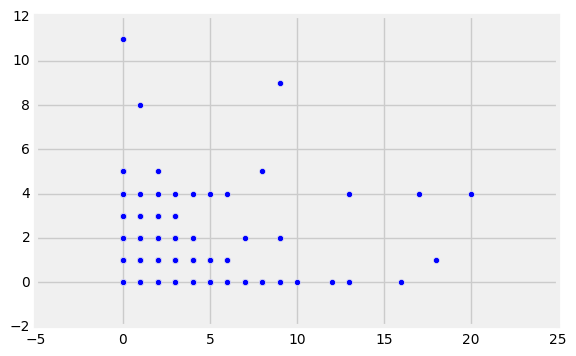

In [25]:
plot_scatter(result,4,1000)

In [ ]:

from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
import pandas as pd

films = { 'body': set(testdict.values()), 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['body', 'cluster'])

In [ ]:
frame['cluster'].value_counts()